<h1 align="center"><code>/gamerule doFireTick true</code></h1>
<p align="center">Brought to you by Leonardo Biason (2045751), Lorenzo Marinelli (2043092) and Oscar Michele Norelli (2046721)</p>

---

This project has been done for the Deep Learning course challenge, which asked to the course participants to build a binary classifier which should recognize whether there is some fire in a picture. We here present a possible implementation of this classifier, which reached an astonishing accuracy of $98.5\%$.

A complete paper can be found [here](https://github.com/ElBi21/doFireTick/blob/main/doFireTick.pdf), with all the details of the ensemble and the training process.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch
import random

# Custom Dataset to include original, flipped, and conditionally augmented flipped images
class AugmentedDataset(Dataset):
    def __init__(self, dataset, additional_transforms=None, augment_prob=0.5):
        """
        Args:
            dataset: The original dataset (e.g., ImageFolder).
            additional_transforms: Additional transformations to apply.
            augment_prob: Probability of applying secondary transformations to flipped images.
        """
        self.dataset = dataset
        self.additional_transforms = additional_transforms
        self.augment_prob = augment_prob

    def __len__(self):
        # Double the dataset size (original + flipped)
        return len(self.dataset) * 2

    def __getitem__(self, idx):
        original_idx = idx % len(self.dataset)  # Get the original image index
        is_flipped = idx >= len(self.dataset)  # Check if it's a flipped image

        image, label = self.dataset[original_idx]

        # Apply horizontal flip if needed
        if is_flipped:
            image = transforms.functional.hflip(image)

            # Randomly apply secondary transformations
            if random.random() < self.augment_prob and self.additional_transforms:
                image = self.additional_transforms(image)

        return image, label


# Define transformations
transform_original = transforms.Compose([
    transforms.ToTensor(),
])

# Define additional transformations for flipped images
additional_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),  # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
    transforms.Lambda(lambda img: torch.clamp(img + torch.randn_like(img) * 0.07, 0.0, 1.0))  # Brightness noise
])

# Load original dataset
all_data_path = r"C:\Users\repea\Downloads\dl2425_challenge_dataset\dl2425_challenge_dataset\train"
#all_data_path = "/kaggle/input/fire-not-fire/dl2425_challenge_dataset/train"
original_dataset = datasets.ImageFolder(root=all_data_path, transform=transform_original)

# Create the augmented dataset
augmented_dataset = AugmentedDataset(
    original_dataset,
    additional_transforms=additional_transforms,
    augment_prob=0.3  # 30% of flipped images will have secondary transformations
)

# Create DataLoader
train_loader = DataLoader(augmented_dataset, batch_size=32, shuffle=True)

# Verify the DataLoader
print(f"Number of training samples (including flipped): {len(train_loader.dataset)}")


Number of training samples (including flipped): 21852


In [4]:
# Combine both datasets into one for splitting
all_data_path = r"C:\Users\repea\Downloads\dl2425_challenge_dataset\dl2425_challenge_dataset\val"
categories = ["0", "1"]

# Define transformations (resize to 224x224 and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert image to PyTorch tensor
])

# Load the dataset
dataset = datasets.ImageFolder(root=all_data_path, transform=transform)


# Create DataLoader for train and test sets
val_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Verify the dataloaders
print(f"Number of training samples: {len(val_loader.dataset)}")

Number of training samples: 3121


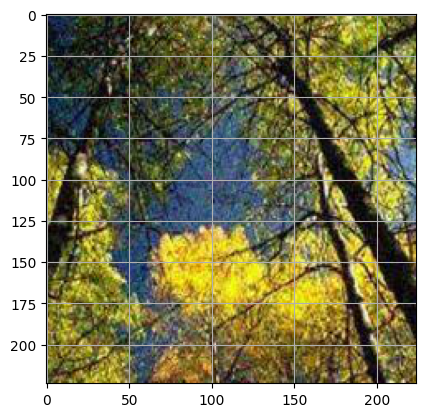

torch.Size([3, 224, 224]) tensor(0)


In [7]:
for batch in val_loader:
    # Plot the first image in the batch
    image_tensor = batch[0][0]
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert to H x W x C for plotting
    plt.imshow(image)
    plt.grid(True)
    plt.axis('on')
    plt.show()
    print (image_tensor.shape, batch[1][0])
    break  # Display only one image

# MODELS


In [18]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super().__init__()
        # use standard CE loss without reducion as basis
        self.CE = nn.CrossEntropyLoss(reduction='none',)
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target):
        '''
        input (B, N)
        target (B)
        '''
        CE_loss = self.CE(input, target)
        pt = torch.exp(-CE_loss) # don't forget the minus here
        focal_loss = (1-pt)**self.gamma * CE_loss

        # apply class weights
        if self.alpha != None:
            focal_loss *= self.alpha.gather(0, target)
        
        if self.reduction == 'mean':
            focal_loss = focal_loss.mean()
        elif self.reduction == 'sum':
            focal_loss = focal_loss.sum()
        return focal_loss

In [42]:
resnet = torchvision.models.resnet152(pretrained=True).to(device)
resnet.fc = nn.Linear(2048,1024)

class lll(nn.Module):
    """Some Information about MyModule"""
    def __init__(self, backbone):
        super(lll, self).__init__()
        self.backbone = backbone
        self.linear = nn.Linear(1024,512)
        self.linear2 = nn.Linear(512,2)
        self.relu=nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.backbone(x))
        x = self.dropout(x)
        x = self.relu(self.linear(x))
        x = self.dropout(x)
        x = self.linear2(x)



        return x
    
model1= lll(resnet).to(device)
optimizer1 = optim.AdamW(model1.parameters(), lr=0.001)
criterion1 = FocalLoss()
###a complex 152 resnet with changed last layer and added subsequent layers, trained with cross entropy loss anf AdamW with decreasing lr rate, data augmentation applied

In [33]:
model2 = torchvision.models.resnet50(weights="ResNet50_Weights.DEFAULT").to(device)
model2.fc = nn.Linear(2048,2).to(device)
optimizer2 = optim.SGD(model2.parameters(), lr=0.1)
criterion2 = nn.CrossEntropyLoss()

#HAVE TO COMMENT THE DATA AUGMENTATION PART TO TRAIN THIS

In [35]:
model3 = torchvision.models.resnet18(weights="ResNet18_Weights.DEFAULT").to(device)
model3.fc = nn.Linear(512,2).to(device)
optimizer3 = optim.SGD(model3.parameters(), lr=0.1)
criterion3 = FocalLoss()

In [ ]:
def train_model(model, train_loader, optimizer, criterion, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            inputs = rgb2stef(inputs.permute(0,2,3,1)).permute(0,3,1,2)
            outputs = model(inputs.to(device))  # Forward pass
            loss = criterion(outputs, labels.to(device))  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            running_loss += loss.item()
            print ("ok")
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


train_model(model2,train_loader_model2, optimizer, criterion_model2, num_epochs=10)
for g in optimizer1.param_groups:
    g['lr'] = g['lr']*0.1
train_model(model2,train_loader_model2, optimizer, criterion_model2, num_epochs=10)
for g in optimizer1.param_groups:
    g['lr'] = g['lr']*0.1
train_model(model2,train_loader_model2, optimizer, criterion_model2, num_epochs=10)
for g in optimizer1.param_groups:
    g['lr'] = g['lr']*0.1
train_model(model2,train_loader_model2, optimizer, criterion_model2, num_epochs=10)

# EnsembleModel

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnsembleModel(nn.Module):
    def __init__(self, model1, model2, model3, mode="average"):
        """
        Ensemble model that combines predictions from models.

        Args:
            model1: First model.
            model2: Second model.
            model3: Third model.
            mode: How to combine predictions ('average', 'weighted', 'vote').
        """
        super(EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        self.mode = mode

    def forward(self, x):
        # Get predictions (logits) from the models
        output1 = self.model1(x)
        output2 = self.model2(x)
        output3 = self.model3(x)

        if self.mode == "average":
            # Combine outputs using simple averaging
            return (output1 + output2 + output3) / 3
        elif self.mode == "weighted":
            # Example of weighted averaging
            w1, w2, w3 = 0.5, 0.3, 0.2  # Example weights
            return w1 * output1 + w2 * output2 + w3 * output3
        elif self.mode == "vote":
            # Majority voting
            # Get predicted class probabilities from each model using softmax
            prob1 = F.softmax(output1, dim=1)
            prob2 = F.softmax(output2, dim=1)
            prob3 = F.softmax(output3, dim=1)

            # Combine probabilities by voting (summing probabilities for each class)
            combined_prob = prob1 + prob2 + prob3

            return combined_prob  # Return the combined probabilities
        else:
            raise ValueError("Unsupported combination mode!")

        
# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to device
model1.to(device)
model2.to(device)
model3.to(device)

# Set models to evaluation mode (important for inference)
model1.eval()
model2.eval()
model3.eval()

# Create the ensemble model
ensemble_model = EnsembleModel(model1, model2, model3, mode="average")
ensemble_model.to(device)


EnsembleModel(
  (model1): lll(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [45]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.to(device))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
        print(f"Test Accuracy: {100 * correct / total}%")

test_model(ensemble_model, val_loader)

Test Accuracy: 60.140980454982376%


In [ ]:
class testDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_paths = [
            os.path.join(image_folder, img) for img in os.listdir(image_folder)
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(image_path)

from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = testDataset(r"C:\Users\repea\Downloads\dl2425_challenge_dataset\dl2425_challenge_dataset\test", transform=transform)
testdataloader = DataLoader(dataset, batch_size=32, shuffle=True) #IL DATASET CON IMMAGINI CON TARGET


def classify_with_dataloader(test_loader, model, output_csv="results.csv", device="cpu"):
    """
    Classifies images from a DataLoader using a PyTorch model and saves the results in a CSV.

    Parameters:
        test_loader (DataLoader): DataLoader containing images to classify.
        model (torch.nn.Module): Pre-trained PyTorch model for classification.
        output_csv (str): Path to save the classification results as a CSV.
        device (str): Device to run the model on ("cpu" or "cuda").
    """
    # Ensure model is on the correct device and set to evaluation mode
    model.to(device)
    model.eval()

    results = []

    # Iterate through the DataLoader
    with torch.no_grad():
        for images, file_names in test_loader:
            images = images.to(device)

            # Model prediction
            outputs = model(images)
            predicted_classes = torch.argmax(outputs, dim=1).cpu().numpy()

            # Collect results
            for file_name, predicted_class in zip(file_names, predicted_classes):
                results.append({"id": file_name, "class": int(predicted_class)})

    # Save results to a CSV file
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"Results saved to {output_csv}")

    # Classify images and save the results
classify_with_dataloader(testdataloader, ensemble_model, output_csv="resultssss.csv", device="cuda")